In [1]:
# ! git clone https://github.com/yutongo/TIGON.git

import anndata
import numpy as np
import sklearn.preprocessing
import sklearn.decomposition
import tqdm.notebook
import pandas as pd
import annoy
import ABCParse

h5ad_path = "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"

adata = anndata.read_h5ad(h5ad_path)
print(adata)

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


### Prepare data for input to TIGON

**A note for clarity**: we have already preprocessed the LARRY dataset and formatted/loaded it as `adata`. During this processed we filtered genes. However we have not modified, transformed, or re-normalized the counts in any way since retrieving them from the original source (link). In the following cells, we will demonstrate the standard scaling and PCA-transform (50 components) we do, which matches previous works (PBA, PRESCIENT, etc).

In [2]:
scaler = sklearn.preprocessing.StandardScaler()
PCA = sklearn.decomposition.PCA(n_components=50)

First, we fit the scaler and PCA without using the test data.

In [3]:
adata.obs['train'] = adata.obs['Well'].isin([0, 1])
X_train = adata[adata.obs['train']].X.copy()

In [4]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_pca = PCA.fit_transform(X_train_scaled)

Now, we can transform all of the data

In [5]:
X = adata.X.copy()
adata.layers['X_scaled'] = X_scaled = scaler.transform(X)
adata.obsm['X_pca'] = PCA.transform(X_scaled)
adata.write_h5ad("./adata.preprocessed.h5ad")

In [6]:
grouped = adata[adata.obs['train']].obs.groupby("Time point")
X_ = [adata[group_df.index].obsm['X_pca'].toarray() for group, group_df in grouped]
Lineage = np.array(X_, dtype=object)[None, :]
print(Lineage.shape)
np.save("./TIGON/Input/Lineage_v2.npy", Lineage)

(1, 3)


### Run TIGON

This section is adapted directly from the training notebook provided here: [link](https://github.com/yutongo/TIGON/blob/main/Notebooks/Training.ipynb).

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append("./TIGON/")
from utility import *

args = create_args()

Name of the data set. Options: EMT; Lineage; Bifurcation; Simulation (default: EMT): Lineage_v2
Time points of data (default: 0, 0.1, 0.3, 0.9, 2.1): 2,4,6
Number of training iterations (default: 5000): 8000
Learning rate (default: 3e-3): .007
Number of sampling points per epoch (default: 100): 100
Dimension of the hidden layer (default: 16): 
Number of hidden layers (default: 4): 
Activation function (default: Tanh): 
GPU device index (default: 0): 
Input Files Directory (default: Input/): TIGON/Input/
Output Files Directory (default: Output/): TIGON/Output_v2/
Random seed (default: 1): 0


In [10]:
if __name__ == '__main__':
    
    random.seed(args.seed)
    torch.manual_seed(args.seed)

    device = torch.device('cuda:' + str(args.gpu)
                            if torch.cuda.is_available() else 'cpu')
    # load dataset
    data_train = loaddata(args,device)
    integral_time = args.timepoints

    time_pts = range(len(data_train))
    leave_1_out = []
    train_time = [x for i,x in enumerate(time_pts) if i!=leave_1_out]


    # model
    func = UOT(in_out_dim=data_train[0].shape[1], hidden_dim=args.hidden_dim,n_hiddens=args.n_hiddens,activation=args.activation).to(device)
    func.apply(initialize_weights)


    # configure training options
    options = {}
    options.update({'method': 'Dopri5'})
    options.update({'h': None})
    options.update({'rtol': 1e-3})
    options.update({'atol': 1e-5})
    options.update({'print_neval': False})
    options.update({'neval_max': 1000000})
    options.update({'safety': None})

    optimizer = optim.Adam(func.parameters(), lr=args.lr, weight_decay= 0.01)
    lr_adjust = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[args.niters-400,args.niters-200], gamma=0.5, last_epoch=-1)
    mse = nn.MSELoss()

    LOSS = []
    L2_1 = []
    L2_2 = []
    Trans = []
    Sigma = []
    
    if args.save_dir is not None:
        if not os.path.exists(args.save_dir):
            os.makedirs(args.save_dir)
        ckpt_path = os.path.join(args.save_dir, 'ckpt.pth')
        if os.path.exists(ckpt_path):
            checkpoint = torch.load(ckpt_path)
            func.load_state_dict(checkpoint['func_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print('Loaded ckpt from {}'.format(ckpt_path))

    try:
        sigma_now = 1
        for itr in range(1, args.niters + 1):
            optimizer.zero_grad()
            
            loss, loss1, sigma_now, L2_value1, L2_value2 = train_model(mse,func,args,data_train,train_time,integral_time,sigma_now,options,device,itr)

            
            loss.backward()
            optimizer.step()
            lr_adjust.step()

            LOSS.append(loss.item())
            Trans.append(loss1[-1].mean(0).item())
            Sigma.append(sigma_now)
            L2_1.append(L2_value1.tolist())
            L2_2.append(L2_value2.tolist())
            
            print('Iter: {}, loss: {:.4f}'.format(itr, loss.item()))
            
            
            if itr % 500 == 0:
                ckpt_path = os.path.join(args.save_dir, 'ckpt_itr{}.pth'.format(itr))
                torch.save({'func_state_dict': func.state_dict()}, ckpt_path)
                print('Iter {}, Stored ckpt at {}'.format(itr, ckpt_path))
                
            
            

    except KeyboardInterrupt:
        if args.save_dir is not None:
            ckpt_path = os.path.join(args.save_dir, 'ckpt.pth')
            torch.save({
                'func_state_dict': func.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, ckpt_path)
            print('Stored ckpt at {}'.format(ckpt_path))
    print('Training complete after {} iters.'.format(itr))
    
    
    ckpt_path = os.path.join(args.save_dir, 'ckpt.pth')
    torch.save({
        'func_state_dict': func.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'LOSS':LOSS,
        'TRANS':Trans,
        'L2_1': L2_1,
        'L2_2': L2_2,
        'Sigma': Sigma
    }, ckpt_path)
    print('Stored ckpt at {}'.format(ckpt_path))

Iter: 1, loss: 44.9938
Iter: 2, loss: 20.2676
Iter: 3, loss: 12.0206
Iter: 4, loss: 8.2417
Iter: 5, loss: 5.9970
Iter: 6, loss: 5.0227
Iter: 7, loss: 3.6932
Iter: 8, loss: 2.8325
Iter: 9, loss: 2.4408
Iter: 10, loss: 2.0296
Iter: 11, loss: 1.5746
Iter: 12, loss: 1.1889
Iter: 13, loss: 1.1135
Iter: 14, loss: 1.0340
Iter: 15, loss: 0.9922
Iter: 16, loss: 0.7661
Iter: 17, loss: 0.8258
Iter: 18, loss: 0.7438
Iter: 19, loss: 0.5437
Iter: 20, loss: 0.5948
Iter: 21, loss: 0.6288
Iter: 22, loss: 0.4687
Iter: 23, loss: 0.5078
Iter: 24, loss: 0.3824
Iter: 25, loss: 0.3157
Iter: 26, loss: 0.4245
Iter: 27, loss: 0.4181
Iter: 28, loss: 0.2703
Iter: 29, loss: 0.3361
Iter: 30, loss: 0.2911
Iter: 31, loss: 0.2668
Iter: 32, loss: 0.2278
Iter: 33, loss: 0.3008
Iter: 34, loss: 0.2159
Iter: 35, loss: 0.2195
Iter: 36, loss: 0.2409
Iter: 37, loss: 0.2694
Iter: 38, loss: 0.2170
Iter: 39, loss: 0.2589
Iter: 40, loss: 0.1705
Iter: 41, loss: 0.2390
Iter: 42, loss: 0.1752
Iter: 43, loss: 0.1583
Iter: 44, loss: 0

### Plot the training loss

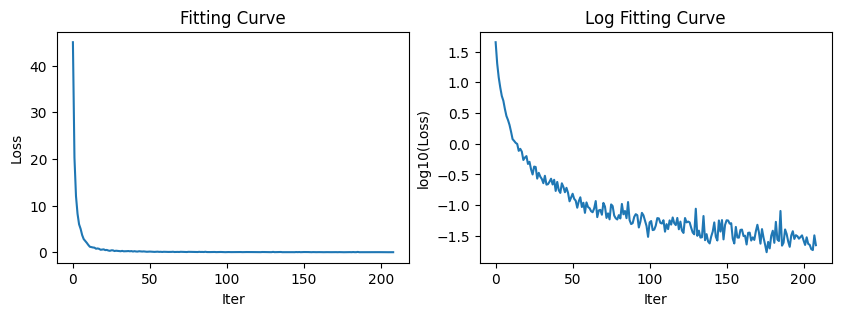

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

y_labels = ["Loss", "log10(Loss)"]
titles = ['Fitting Curve', 'Log Fitting Curve']
for en, ax in enumerate(axes):
    ax.set_xlabel("Iter")
    ax.set_ylabel(y_labels[en])
    ax.set_title(titles[en])
    
axes[0].plot(LOSS)
axes[1].plot(np.log10(LOSS))

In [24]:
integral_time = args.timepoints

time_pts = range(len(data_train))
leave_1_out = []
train_time = [x for i,x in enumerate(time_pts) if i!=leave_1_out]

In [25]:
if args.save_dir is not None:
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    ckpt_path = os.path.join(args.save_dir, 'ckpt.pth')
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path,map_location=torch.device('cpu'))
        func.load_state_dict(checkpoint['func_state_dict'])
        print('Loaded ckpt from {}'.format(ckpt_path))

Loaded ckpt from TIGON/Output_v2/ckpt.pth


In [29]:
F_obs = pd.read_csv("./F_obs_copy.csv", index_col=0)
F_obs.index = F_obs.index.astype(str)

### Use the trained model to make predictions

I have slightly modified the `plot_3d` function to generate new predictions from the model, in hopes of minimizing differences between how we generate trajectories sampled from the model.

In [30]:
def plot_3d(z_t0, func, data_train, train_time, integral_time, args, device):

    viz_samples = 20
    sigma_a = 0.001

    t_list = (
        []
    )  # list(reversed(integral_time))#integral_time #np.linspace(5, 0, viz_timesteps)
    # options.update({'t_eval':t_list})

    z_t_samples = []
    z_t_data = []
    v = []
    g = []
    t_list2 = []
    odeint_setp = gcd_list([num * 100 for num in integral_time]) / 100
    integral_time2 = np.arange(
        integral_time[0], integral_time[-1] + odeint_setp, odeint_setp
    )
    integral_time2 = np.round_(integral_time2, decimals=2)
    plot_time = list(reversed(integral_time2))
    sample_time = np.where(np.isin(np.array(plot_time), integral_time))[0]
    sample_time = list(reversed(sample_time))

    with torch.no_grad():
        for i in range(len(integral_time)):

            #             z_t0 =  data_train[i]

            #             z_t_data.append(z_t0.cpu().detach().numpy())
            t_list2.append(integral_time[i])

        # traj backward
        # instead, we supply z_t0
        #         z_t0 =  Sampling(viz_samples, train_time, len(train_time)-1,data_train,sigma_a,device)
        #         print(f"z_t0.shape: {z_t0.shape}")
        # z_t0 = z_t0[z_t0[:,2]>1]
        logp_diff_t0 = torch.zeros(z_t0.shape[0], 1).type(torch.float32).to(device)
        g0 = torch.zeros(z_t0.shape[0], 1).type(torch.float32).to(device)
        v_t = func(
            torch.tensor(integral_time[-1]).type(torch.float32).to(device),
            (z_t0, g0, logp_diff_t0),
        )[
            0
        ]  # True_v(z_t0)
        g_t = func(
            torch.tensor(integral_time[-1]).type(torch.float32).to(device),
            (z_t0, g0, logp_diff_t0),
        )[1]

        v.append(v_t.cpu().detach().numpy())
        g.append(g_t.cpu().detach().numpy())
        z_t_samples.append(z_t0.cpu().detach().numpy())
        t_list.append(plot_time[0])
        options = {}
        options.update({"method": "Dopri5"})
        options.update({"h": None})
        options.update({"rtol": 1e-3})
        options.update({"atol": 1e-5})
        options.update({"print_neval": False})
        options.update({"neval_max": 1000000})
        options.update({"safety": None})

        options.update({"t0": integral_time[-1]})
        options.update({"t1": 0})
        options.update({"t_eval": plot_time})
        z_t1, _, logp_diff_t1 = odesolve(
            func, y0=(z_t0, g0, logp_diff_t0), options=options
        )

        return z_t1

        for i in range(len(plot_time) - 1):
            v_t = func(
                torch.tensor(plot_time[i + 1]).type(torch.float32).to(device),
                (z_t1[i + 1], g0, logp_diff_t1),
            )[
                0
            ]  # True_v(z_t0)
            g_t = func(
                torch.tensor(plot_time[i + 1]).type(torch.float32).to(device),
                (z_t1[i + 1], g0, logp_diff_t1),
            )[1]

            z_t_samples.append(z_t1[i + 1].cpu().detach().numpy())
            g.append(g_t.cpu().detach().numpy())
            v.append(v_t.cpu().detach().numpy())
            t_list.append(plot_time[i + 1])

        aa = 5  # 3
        angle1 = 10  # 30
        angle2 = 75  # 30
        trans = 0.8
        trans2 = 0.4
        widths = 0.2  # arrow width
        ratio1 = 0.4
        #         fig = plt.figure(figsize=(4*2,3*2), dpi=200)
        #         plt.tight_layout()
        #         plt.margins(0, 0)
        v_scale = 5


#         plt.tight_layout()
#         plt.axis('off')
#         plt.margins(0, 0)
#         #fig.suptitle(f'{t:.1f}day')
#         ax1 = plt.axes(projection ='3d')
#         ax1.grid(False)
#         ax1.set_xlabel('UMAP1')
#         ax1.set_ylabel('UMAP2')
#         ax1.set_zlabel('UMAP3')
#         ax1.set_xlim(-2,2)
#         ax1.set_ylim(-2,2)
#         ax1.set_zlim(-2,2)
#         ax1.set_xticks([-2,2])
#         ax1.set_yticks([-2,2])
#         ax1.set_zticks([-2,2])
#         ax1.view_init(elev=angle1, azim=angle2)
#         ax1.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#         ax1.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#         ax1.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#         ax1.invert_xaxis()
#         ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax1), np.diag([1, 1, 0.7, 1]))
#         line_width = 0.3


#         color_wanted = [np.array([250,187,110])/255,
#                         np.array([173,219,136])/255,
#                         np.array([250,199,179])/255,
#                         np.array([238,68,49])/255,
#                         np.array([206,223,239])/255,
#                         np.array([3,149,198])/255,
#                         np.array([180,180,213])/255,
#                         np.array([178,143,237])/255]
#         for j in range(viz_samples): #individual traj
#             for i in range(len(plot_time)-1):
#                 ax1.plot([z_t_samples[i][j,0],z_t_samples[i+1][j,0]],
#                             [z_t_samples[i][j,1],z_t_samples[i+1][j,1]],
#                             [z_t_samples[i][j,2],z_t_samples[i+1][j,2]],
#                             linewidth=0.5,color ='grey',zorder=2)


#         # add inferrred trajecotry
#         for i in range(len(sample_time)):
#             ax1.scatter(z_t_samples[sample_time[i]][:,0],z_t_samples[sample_time[i]][:,1],z_t_samples[sample_time[i]][:,2],s=aa*10,linewidth=0, color=color_wanted[i],zorder=3)
#             ax1.quiver(z_t_samples[sample_time[i]][:,0],z_t_samples[sample_time[i]][:,1],z_t_samples[sample_time[i]][:,2],
#                        v[sample_time[i]][:,0]/v_scale,v[sample_time[i]][:,1]/v_scale,v[sample_time[i]][:,2]/v_scale, color='k',alpha=1,linewidths=widths*2,arrow_length_ratio=0.3,zorder=4)


#         for i in range(len(integral_time)):
#             ax1.scatter(z_t_data[i][:,0],z_t_data[i][:,1],z_t_data[i][:,2],s=aa,linewidth=line_width,alpha = 0.7, facecolors='none', edgecolors=color_wanted[i],zorder=1)

#         #plt.savefig(os.path.join(args.save_dir, f"traj_3d.pdf"),format="pdf",pad_inches=0.1, bbox_inches='tight')
#         plt.show()

In [32]:
def assign_labels(idx, z_t1, adata, obs_key="Cell type annotation"):
    """"""
    X_query = z_t1.cpu().detach().numpy()[1:].reshape(-1, 50)
    nn = np.array(
        [idx.get_nns_by_vector(X_query[i], 20) for i in range(len(X_query))]
    ).flatten()
    query_df = pd.DataFrame(adata[nn].obs[obs_key].to_numpy().reshape(-1, 20)).T
    return (
        pd.DataFrame([query_df[i].value_counts().idxmax() for i in query_df.columns])
        .fillna(0)
        .sort_index(axis=1)
    )

In [33]:
X_use = adata.obsm["X_pca"]
n_trees = 10
idx = annoy.AnnoyIndex(50, "euclidean")
[idx.add_item(i, X_use[i]) for i in range(len(adata))]
idx.build(n_trees)

X_pca = torch.Tensor(adata[F_obs.index].obsm["X_pca"].toarray())
print(X_pca.shape)

torch.Size([2081, 50])


In [34]:
predicted = {}
for i in tqdm.notebook.tqdm(range(len(X_pca))):
    key = F_obs.index[i]
    z_t0 = X_pca[i].expand(2000, -1).to("cuda:0")
    z_t1 = plot_3d(z_t0, func, data_train, train_time, integral_time, args, device)
    predicted[key] = assign_labels(idx, z_t1, adata, obs_key="Cell type annotation").rename(
        {0: key}, axis=1
    )

  0%|          | 0/2081 [00:00<?, ?it/s]

In [36]:
pred_labels = pd.DataFrame({k: v[k] for k, v in predicted.items()})
pred_labels.to_csv("pred_labels.csv")

In [37]:
F_hat = (
    pd.DataFrame(
        {key: pred_labels[key].value_counts().to_dict() for key in pred_labels}
    )
    .T.fillna(0)
    .drop("Undifferentiated", axis=1)
)
F_hat.to_csv("F_hat.TIGON.csv")

In [41]:
sum(F_hat.sum(1) > 0) # only 105 lineages predicted to accumulate d4, d6 cells at states other than Undiff.

105

In [42]:
# make sure predicted matrix contains all labels/fates that true matrix contains
for fate in F_obs.columns:
    if not fate in F_hat:
        F_hat[fate] = 0

### Compute accuracy

In [46]:
# we need to indicate where no fate was predicted so that it does not accidentally
# appear to predict a fate upon doing .idxmax()
non_fated_ix = np.where(F_hat.sum(1) == 0)
y_pred = F_hat.idxmax(1)
y_pred[non_fated_ix[0]] = "Undifferentiated"

# now compute accuracy score
y_pred = y_pred.tolist()
y_true = F_obs.idxmax(1).tolist()

accuracy = sklearn.metrics.accuracy_score(y_pred, y_true)
print("Accuracy: {:.3f}%".format(accuracy * 100))

Accuracy: 4.085%


### Comparison to PBA

Using PBA as common point of comparison, in the TIGON benchmark, they demonstrate that TIGON And other CNF-based methods far outperform PBA. I was able to run PBA on this same benchmark setup and get an accuracy score of: **36.321%**. 

That being said, I was **not able to run PBA as described and match the performance in Neu/Mon correlation reported in their 2020 *Science* paper** and subsequently re-described in PRESCIENT, TIGON, and others.